In [91]:
#copyright joshuah.rainstar@gmail.com
from __future__ import annotations
import math
import typing

import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from typing import Dict, Tuple

class ZLSGate(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # smooth gate
        x = 4.0 * x
        sp = F.softplus(x)
        sa = torch.sigmoid(0.5 * x)
        ba = sa * (1.0 - sa)
        z = sp - 2.772588722239781 * ba  # 4 * ln(2)
        return 1.0 - torch.exp(-(z + 1e-8))

def _norm(v, eps: float = 1e-12):
    return torch.linalg.vector_norm(v, dim=-1, keepdim=True).clamp_min(eps)


def _unit(v, eps: float = 1e-12):
    return v / _norm(v, eps)

    
@torch.no_grad()
def phase_transport_between(
    curr: torch.Tensor,
    prev: torch.Tensor,
    tau: float = 1e-6,          # semantic threshold (unchanged)
    eps: float = 1e-12          # numeric epsilon (NEW: decoupled from tau)
) -> torch.Tensor:
    assert curr.shape == prev.shape and curr.dim() == 3
    B, T, C = curr.shape

    # Units (reuse norms) — clamp with eps (NOT tau)
    nu = torch.linalg.vector_norm(curr, dim=-1, keepdim=True).clamp_min(eps)   # (B,T,1)
    nv = torch.linalg.vector_norm(prev, dim=-1, keepdim=True).clamp_min(eps)   # (B,T,1)
    u = curr / nu
    v = prev / nv

    w = curr - prev
    c = (u * v).sum(dim=-1, keepdim=True)                                      # (B,T,1)

    # Masks (semantic thresholds use tau)
    near_pos = (c >  1.0 - tau)                                                # (B,T,1)
    near_neg = (c < -1.0 + tau)                                                # (B,T,1)
    small_u  = (nu < tau)                                                      # (B,T,1)
    small_v  = (nv < tau)                                                      # (B,T,1)
    trivial  = near_pos | small_u | small_v                                    # (B,T,1)

    # General branch
    denom = (1.0 + c).clamp_min(eps)                                           # (B,T,1)
    a = (v * w).sum(dim=-1, keepdim=True)                                      # (B,T,1)
    b = (u * w).sum(dim=-1, keepdim=True)                                      # (B,T,1)
    Kw  = u * a - v * b                                                        # (B,T,C)
    K2w = u * (a * c - b) + v * (b * c - a)                                    # (B,T,C)
    y_gen = w - Kw + (K2w / denom)                                             # (B,T,C)

    # Antipodal candidate
    if C == 1:
        y_neg = -w
    else:
        # Keep this normalization stable with eps as well
        idx = torch.argmin(v.abs().reshape(-1, C), dim=1, keepdim=True)        # (B*T,1)
        s = v.reshape(-1, C).gather(1, idx)                                    # (B*T,1)
        p = -s * v.reshape(-1, C)
        onehot = F.one_hot(idx.squeeze(-1), num_classes=C).to(s.dtype)
        p = p + onehot
        n = torch.linalg.vector_norm(p, dim=1, keepdim=True).clamp_min(eps)
        p = (p / n).view(B, T, C)
        proj_v = (v * w).sum(dim=-1, keepdim=True) * v                         # (B,T,C)
        proj_p = (p * w).sum(dim=-1, keepdim=True) * p                         # (B,T,C)
        y_neg = w - 2.0 * proj_v - 2.0 * proj_p

    # Fuse selections
    y = torch.where(trivial, w, y_gen)
    y = torch.where(near_neg, y_neg, y)
    return y

# ===========================================================
# Multi-scale features (vectorized pyramid)
# ===========================================================
class CausalCentroidPyramid(nn.Module):
    """
    Child-driven centroid pyramid.
    Level s (s=0..K-1) covers window 2^(s+1):
      - child stream z_0 := x
      - y_s(t) = PT(z_s(t), z_s(t - 2^s))             # distance between bracketing child markers
      - z_{s+1}(t) = z_s(t) - 0.5 * y_s(t)            # centerpoint of the window (right-anchored)
    Unsupported prefix t < 2^s is zeroed.
    Returns feats: (B,T,K,C) with feats[:,:,s,:] = y_s.
    """
    def __init__(self, num_scales: int, tau: float = 1e-6):
        super().__init__()
        assert num_scales >= 1
        self.K = num_scales
        self.tau = float(tau)

    @torch.no_grad()
    def forward(self, x: torch.Tensor, mask_early: bool = True) -> torch.Tensor:
        assert x.dim() == 3
        B, T, C = x.shape
        device, dtype = x.device, x.dtype

        feats = []
        z = x.clone()  # child stream for current level

        for s in range(self.K):
            d = 1 << s  # child lag (1,2,4,...)

            left = torch.zeros_like(z)
            if T > d:
                left[:, d:, :] = z[:, :-d, :].contiguous()

            y = phase_transport_between(z, left, tau=self.tau)  # (B,T,C)

            if mask_early:
                y[:, :d, :].zero_()

            feats.append(y)

            # next-level child markers (centerpoints from the two halves)
            z = z - 0.5 * y
            if mask_early:
                z[:, :d, :].zero_()

        return torch.stack(feats, dim=2)  # (B,T,K,C)


        # ----- STREAMING STATE FOR INFERENCE -----
class CausalPyramidState:
    """
    Keeps ring buffers of child marker streams z_s for s=0..K-1 with lengths 2^s.
    At step t:
      - z_0(t) = x_t
      - for s: y_s(t) = PT(z_s(t), z_s(t - 2^s)); z_{s+1}(t) = z_s(t) - 0.5*y_s(t)
    """
    def __init__(self, num_scales: int, C: int, device, batch_size: int = 1, tau: float = 1e-6):
        self.K = num_scales
        self.C = C
        self.B = batch_size
        self.device = device
        self.tau = float(tau)
        self.t = 0

        # ring buffers for child streams z_s
        self.buffers = [torch.zeros(batch_size, (1 << s), C, device=device) for s in range(self.K)]
        self.ptrs = [0 for _ in range(self.K)]

    def _read(self, level: int, r: int):
        if self.t < r:
            return torch.zeros(self.B, self.C, device=self.device)
        L = self.buffers[level].size(1)
        idx = (self.ptrs[level] - r) % L
        return self.buffers[level][:, idx, :]

    def _push(self, level: int, value: torch.Tensor):
        L = self.buffers[level].size(1)
        self.buffers[level][:, self.ptrs[level], :] = value
        self.ptrs[level] = (self.ptrs[level] + 1) % L

    @torch.no_grad()
    def step(self, x_t: torch.Tensor) -> torch.Tensor:
        B, C = x_t.shape
        assert B == self.B and C == self.C

        feats = []
        z_t = x_t.clone()  # z_0(t)

        for s in range(self.K):
            d = 1 << s
            left = self._read(level=s, r=d)           # z_s(t-d)
            y_t = phase_transport_between(z_t[:, None, :], left[:, None, :], tau=self.tau).squeeze(1)
            if self.t < d:
                y_t.zero_()
            feats.append(y_t)

            # push current child stream for this level
            self._push(level=s, value=z_t)

            # next level child marker z_{s+1}(t)
            z_t = z_t - 0.5 * y_t
            if self.t < d:
                z_t.zero_()

        self.t += 1
        return torch.stack(feats, dim=1)  # (B,K,C)






class SemanticClusterFeaturesCausal(nn.Module):
    """
    Unified wrapper:
      - forward(x): vectorized for training
      - step(x_t, state): single-step for inference with cache
    """
    def __init__(self, num_scales: int, tau: float = 1e-6):
        super().__init__()
        self.pyramid = CausalCentroidPyramid(num_scales=num_scales, tau=tau)
        self.K = num_scales
        self.tau = float(tau)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.pyramid(x)  # (B,T,K,C)

    @torch.no_grad()
    def step(self, x_t: torch.Tensor, state: CausalPyramidState) -> torch.Tensor:
        return state.step(x_t)  # (B,K,C)

        
        
class Cell(nn.Module):
    def __init__(self, dim_in: int, hidden: int,dim_out:int):
        super().__init__()
        self.fc1 = nn.Linear(dim_in, hidden, bias=True) 
        self.fc2 = nn.Linear(hidden, dim_out, bias=True)
        self.act = nn.GELU()
    def forward(self, x):
      
        return self.fc2(self.act(self.fc1(x))) 




class GPTSemanticBlock(nn.Module):
    def __init__(self, config: GPTConfig, features):
        super().__init__()
        C = config.n_embd
        self.C = C
        self.K = config.n_scales
        self.L = self.K+1
        self.features = features
        width = self.L*self.C

        self.drop = nn.Dropout(config.dropout)
        self.ln = nn.LayerNorm(width)
        self.mlp = Cell(width, width*2,width)
        # NEW: highest-scale low-pass bank (e.g., M=3)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, C = x.shape

        out = self.drop(self.ln(self.mlp(x)))
        return out

    # single-step incremental
    @torch.no_grad()
    def step(self, x_t: torch.Tensor) -> torch.Tensor:
        B, C = x_t.shape
        return self.drop(self.ln(self.mlp(x_t)))



def _is_prime(n: int) -> bool:
    if n < 2: return False
    if n % 2 == 0: return n == 2
    r = int(n**0.5)
    for f in range(3, r+1, 2):
        if n % f == 0: return False
    return True

def _factorize(n: int):
    f, cnt = [], {}
    d = 2
    while d * d <= n:
        while n % d == 0:
            cnt[d] = cnt.get(d, 0) + 1
            n //= d
        d += 1 if d == 2 else 2
    if n > 1: cnt[n] = cnt.get(n, 0) + 1
    return list(cnt.keys())

def _primitive_root(p: int) -> int:
    # p must be prime
    phi = p - 1
    factors = _factorize(phi)
    for g in range(2, p):
        ok = True
        for q in factors:
            if pow(g, phi // q, p) == 1:
                ok = False
                break
        if ok:
            return g
    raise RuntimeError("no primitive root found")

def _welch_costas_perm(V: int, device=None):
    """
    Welch Costas permutation σ on {0..V-1}, where V = p-1 for prime p.
    σ[i] = g^(i+1) mod p, mapped to 0..V-1 by subtracting 1.
    """
    p = V + 1
    if not _is_prime(p):
        return None
    g = _primitive_root(p)
    sigma = torch.empty(V, dtype=torch.long, device=device)
    for i in range(V):
        sigma[i] = pow(g, i + 1, p) - 1
    return sigma  # permutation of 0..V-1

def _coprime_mul_perm(V: int, device=None):
    """
    Fallback: σ[i] = (a*i + b) % V with gcd(a, V)=1 and a not ≡ ±1 mod V.
    Not Costas, but non-monotone and well-distributed.
    """
    # pick a
    a = None
    for cand in range(2, V):
        if math.gcd(cand, V) == 1 and cand % V not in (1, V-1):
            a = cand
            break
    if a is None:
        a = 1  # degenerate small V
    b = V // 3
    i = torch.arange(V, device=device)
    return ((a * i + b) % V).long()

def _perm_inverse(sigma: torch.Tensor) -> torch.Tensor:
    inv = torch.empty_like(sigma)
    inv[sigma] = torch.arange(sigma.numel(), device=sigma.device)
    return inv


class FlatRollEmbed(nn.Module):
    """
    Embedding matrix W in R^{V x D} built as:
      W = roll_rows(x) + S
    where x ∈ R^D has |FFT(x)|^2 flat (k=1..D-1) and DC=0, roll_rows(x)[r] = roll(x, r % D),
    and S adds a single spike per row at column (r + M) % D, with M = argmax(x) and scale N = 1/(x[M]+eps).

    Works for any vocab_size V and embedding dim D.
    """

    def __init__(self, config, scale: str = "box", seed: int = 0,
                 freeze: bool = True, dtype=None, device=None):
        super().__init__()
        V = int(config.vocab_size)
        D = int(config.n_embd)
        dtype = dtype or torch.float32
        eps = 1e-12

        # base vector x ∈ R^D with flat spectrum, DC=0
        x = self._make_base(D, scale=scale, seed=seed, dtype=dtype, device=device)  # [D]

        # circulant-like rows: row r is x rolled by (r % D)
        # (vectorized loop for clarity; can be optimized further if needed)
        shifts = torch.arange(V, device=device)
        rows = [torch.roll(x, shifts=int(s.item() % D), dims=0) for s in shifts]
        W = torch.stack(rows, dim=0).to(dtype)

        # align a single positive extremum via a "tower" S
        M = int(torch.argmax(x))          # index of max in x
        pm = x[M].item()
        N = 1.0 / (pm + eps)              # safe reciprocal

        # S[r, (r + M) % D] = N
        r_idx = torch.arange(V, device=device)
        c_idx = (r_idx + M) % D
        S = torch.zeros((V, D), dtype=dtype, device=device)
        S[r_idx, c_idx] = N

        mixed = W + S
        self.embed = nn.Embedding.from_pretrained(mixed, freeze=freeze)

    @staticmethod
    def _make_base(D: int, scale: str = "box", seed: int = 0,
                   dtype=torch.float32, device=None) -> torch.Tensor:
        """
        Build x ∈ R^D where |FFT(x)| is flat for k=1..D-1 and DC=0.

        scale:
          - "unit": ||x||_2 = 1
          - "box":  max|x_i| = 1
        """
        # Build on CPU, then move to device at the end.
        # Use complex64 for float/bfloat/half; complex128 otherwise.
        if dtype in (torch.float16, torch.bfloat16, torch.float32):
            complex_dtype = torch.complex64
            work_float = torch.float32
        else:
            complex_dtype = torch.complex128
            work_float = torch.float64

        g = torch.Generator().manual_seed(seed)
        X = torch.zeros(D, dtype=complex_dtype)

        # DC bin = 0
        X[0] = torch.tensor(0, dtype=complex_dtype)

        if D % 2 == 0:
            # bins 1..D/2-1 are complex-conjugate pairs; Nyquist bin must be real
            for k in range(1, D // 2):
                phi = torch.rand((), generator=g, dtype=work_float) * (2 * math.pi)
                val = torch.cos(phi).to(work_float) + 1j * torch.sin(phi).to(work_float)
                val = val.to(complex_dtype)
                X[k] = val
                X[D - k] = torch.conj(val)
            # Nyquist bin (real, ±1)
            X[D // 2] = (1.0 if torch.rand((), generator=g) < 0.5 else -1.0)
        else:
            for k in range(1, (D - 1) // 2 + 1):
                phi = torch.rand((), generator=g, dtype=work_float) * (2 * math.pi)
                val = torch.cos(phi).to(work_float) + 1j * torch.sin(phi).to(work_float)
                val = val.to(complex_dtype)
                X[k] = val
                X[D - k] = torch.conj(val)

        x = torch.fft.ifft(X).real  # real length-D base vector (float32/64)
        x = x.to(work_float)

        if scale == "unit":
            x = x / (x.norm() + 1e-12)
        elif scale == "box":
            x = x / (x.abs().max() + 1e-12)
        else:
            raise ValueError("scale must be 'unit' or 'box'")

        x = x.to(dtype)
        if device is not None:
            x = x.to(device)
        return x

    def forward(self, input_ids: torch.LongTensor):
        # (batch, seq_len, D)
        return self.embed(input_ids)


        
@dataclass
class GPTConfig:
    block_size: int = 2048
    vocab_size: int = 66 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 6
    n_head:int = 6
    n_embd: int = 66 #tied to vocab
    n_scales:int = 3#more than 3 has no real meaning
  
    dropout: float = 0.1

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config
        self.n_embd = config.n_embd
        self.C = self.n_embd
        self.K = config.n_scales
        self.width = (self.K+1)*self.C
        self.features = SemanticClusterFeaturesCausal(num_scales=config.n_scales, tau=1e-6)
        self.transformer = nn.ModuleDict(dict(
            wte = FlatRollEmbed(config),
            h = nn.ModuleList([GPTSemanticBlock(config,self.features) for _ in range(config.n_layer)]),
        ))

        self.lm_head = nn.Linear( self.width , self.config.vocab_size, bias=False)
        
    # ---------- forward ----------
    def forward(self, idx, targets=None, eprint=False):
        device = idx.device
        b, t = idx.size()
        x = self.transformer.wte(idx) 

        
        feats = self.features(x)                  # (B,T,K,C), K = 1 + (K-1) deltas
        # build low-pass bank on μ_top(x) only, append as extra K channels
        feats = feats.reshape(b,t,((self.K)*self.C))
        x = torch.cat([x,feats], dim=-1)   

    
        for i, block in enumerate(self.transformer.h):
                x= x + block(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                targets.view(-1),
                ignore_index=-1
            )
        else:
            logits = self.lm_head(x[:, [-1], :])
            loss = None
        return logits, loss


    @torch.no_grad()
    def generate_greedy(model: nn.Module, idx: torch.LongTensor, max_new_tokens: int, block_size: int):
        """
        model: your GPT with:
           - transformer.wte (embedding)
           - transformer.h : list[GPTSemanticBlock]
           - lm_head
        idx: (B, T0) prompt token ids
        """
        device = next(model.parameters()).device
        B = idx.size(0)
        # per-block feature caches
        feat_states = [CausalPyramidState(model.config.n_scales, model.config.n_embd, device, batch_size=B)
                       for _ in model.transformer.h]
  
    
        # 1) prime caches with the prompt (causal, one step at a time)
        for t in range(idx.size(1)):
            x_t = x_all[:, t, :]
            feats_t = model.features.step(x_t, feat_states)     # (B, K, C)
            fused = feats_t.reshape(B,((self.K)*self.C))
            x_t = torch.cat([x_t,fused], dim=-1)     # (B,T,K+M,C)



            for i, blk in enumerate(model.transformer.h):
                x_t =x_t +  blk.step(x_t)      # per-block step

        # 2) roll out new tokens
        out = [idx]
        cur = idx
        for _ in range(max_new_tokens):
            # last token embedding
            last_idx = cur[:, -1]                      # (B,)
            x_t = model.transformer.wte(last_idx)      # (B,C)
            feats_t = model.features.step(x_t, feat_states)     # (B, K, C)
            fused = feats_t.reshape(B,((model.K)*model.C))
            x_t = torch.cat([x_t,fused], dim=-1)     # (B,T,K+M,C)
            
            for i, blk in enumerate(model.transformer.h):
                x_t = x_t  + blk.step(x_t)                # (B,C)
  

            logits = model.lm_head(x_t)                # (B,V)
            next_idx = torch.argmax(logits, dim=-1, keepdim=True)  # greedy; swap to sampling if you like
            out.append(next_idx)
            cur = torch.cat([cur, next_idx], dim=1)
            # keep only last block_size tokens in cur (typical AR convenience)
            if cur.size(1) > block_size:
                cur = cur[:, -block_size:]
        return torch.cat(out, dim=1)


In [92]:
import requests, os

base_url = "https://huggingface.co/datasets/cambridge-climb/BabyLM/resolve/main/clean/10M/"
target_dir = "./babylm_10m_cleaned"
os.makedirs(target_dir, exist_ok=True)

file_names = [
    "aochildes.txt",
    "cbt.txt",
    "children_stories.txt",
    "gutenberg.txt",
    "qed.txt",
    "simple_wikipedia.txt",
    "switchboard.txt",
    "wikipedia.txt"
]

# Optional addition: Shakespeare from another dataset
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt"
shakespeare_fname = "shakespeare.txt"

# Combined download logic
all_files = [(base_url + fname, fname) for fname in file_names]
all_files.append((shakespeare_url, shakespeare_fname))  # Add Shakespeare


# Download loop
for url, fname in all_files:
    out_path = os.path.join(target_dir, fname)
    print(f"📥 Downloading {fname}...")
    resp = requests.get(url)
    if resp.status_code == 200:
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(resp.text)
    else:
        print(f"❌ Failed to download {fname} ({resp.status_code})")

print(f"✅ Done. Files saved to {target_dir}")

📥 Downloading aochildes.txt...
📥 Downloading cbt.txt...
📥 Downloading children_stories.txt...
📥 Downloading gutenberg.txt...
📥 Downloading qed.txt...
📥 Downloading simple_wikipedia.txt...
📥 Downloading switchboard.txt...
📥 Downloading wikipedia.txt...
📥 Downloading shakespeare.txt...
✅ Done. Files saved to ./babylm_10m_cleaned


In [93]:
import os
import pickle
import numpy as np

# === Paths ===
source_dir = "./babylm_10m_cleaned"
out_dir    = "./babylm_char_tokenized"
os.makedirs(out_dir, exist_ok=True)

file_names = [
    "shakespeare.txt"#,#"aochildes.txt", "cbt.txt", "children_stories.txt", "gutenberg.txt",
    #"qed.txt", "simple_wikipedia.txt", "switchboard.txt", "wikipedia.txt"
]

# === Load and split ===
train_texts, val_texts = [], []
char_set = set()

for fname in file_names:
    with open(os.path.join(source_dir, fname), encoding="utf-8") as f:
        lines = f.readlines()
        n = len(lines)
        split = int(0.9 * n)
        train_part = "".join(lines[:split])
        val_part   = "".join(lines[split:])
        train_texts.append(train_part)
        val_texts.append(val_part)
        char_set.update(train_part)
        char_set.update(val_part)

full_train = "\n".join(train_texts)
full_val   = "\n".join(val_texts)

# === Final vocab ===
char_set = sorted(set(char_set))
vocab_chars = ["<unk>"] + [c for c in char_set if c != "<unk>"]

stoi = {ch: i for i, ch in enumerate(vocab_chars)}
itos = {i: ch for ch, i in stoi.items()}

# === Encode function ===
def encode(text):
    return [stoi.get(c, 0) for c in text]

train_ids = np.array(encode(full_train), dtype=np.uint16)
val_ids   = np.array(encode(full_val),   dtype=np.uint16)

# === Save ===
train_ids.tofile(os.path.join(out_dir, "train.bin"))
val_ids.tofile(os.path.join(out_dir, "val.bin"))



with open(os.path.join(out_dir, "meta.pkl"), "wb") as f:
    pickle.dump({
        "vocab_size": len(stoi),
        "stoi": stoi,
        "itos": itos
    }, f)

print(f"✅ Char tokenizer finalized.")
print(f"🧾 Train tokens: {len(train_ids)} | Val tokens: {len(val_ids)}")
print(f"🔤 Vocab size: {len(stoi)}")

✅ Char tokenizer finalized.
🧾 Train tokens: 1016242 | Val tokens: 99152
🔤 Vocab size: 66


In [95]:
# import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 128
batch_size = 8

# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap edata (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device, jitter=63, p_aligned=0.5, pad_len=0):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.pad_len = int(pad_len)
        self.sample_len = self.block_size + self.pad_len  # X length
        self.total = len(self.data) - self.sample_len - 1
        self.n_blocks = self.total // self.sample_len
        self.jitter = int(jitter)          # small random offset added to aligned start
        self.p_aligned = float(p_aligned)  # mix aligned and jittered

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.sample_len), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)

        for i in range(self.batch_size):
            # choose a base aligned block
            base_block = np.random.randint(0, self.n_blocks)
            start = base_block * self.sample_len

            # with probability, add a small jitter (keeps cache-friendly contiguous reads)
            if np.random.rand() > self.p_aligned:
                j = np.random.randint(0, self.jitter + 1)
                start = min(start + j, self.total)  # stay in range

            X[i] = self.data[start : start + self.sample_len]
            # targets correspond to the final block_size visible steps
            Y[i] = self.data[start + 1 + self.pad_len : start + 1 + self.pad_len + self.block_size]


        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )


config = GPTConfig(
    vocab_size=len(stoi),
    n_layer=4,
    n_embd=vocab_size,
    block_size=block_size,
    dropout = 0.1,
)
train_dataset = GPUBatchDataset(train_ids, block_size, batch_size, device, pad_len=0)
# === DataLoader ===
train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)

model = GPT(config)
model = torch.compile(model)
model = model.to(device)

In [96]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
losses = []
def train_epoch():
    model.train()
    total_loss = 0
    it = 0
    for xb, yb in train_loader:
          xb, yb = xb[0], yb[0]  # unwrap batch dimension
          optimizer.zero_grad()
          it = it + 1
          logits, loss = model(xb, yb)
          loss = loss
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()
          total_loss += loss.item()
          losses.append(loss.item())
          if it % 10 == 0: print(loss.item()) 
    return total_loss / len(train_loader)

# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

2.9042234420776367
2.4511091709136963
2.3599181175231934
2.400890350341797
2.346912145614624
2.176090955734253
2.1745569705963135
2.138833522796631
2.215945243835449
2.105602979660034
2.139035940170288
2.106557846069336
1.9816009998321533
2.0175578594207764
1.9958734512329102
2.0062508583068848
2.1174323558807373
1.9690488576889038
2.043478488922119
2.013014793395996
2.00122332572937
1.9801832437515259
1.7857928276062012
1.8777629137039185
2.028447389602661
1.9042567014694214
1.8829174041748047
1.9186255931854248
1.9097460508346558
1.9640905857086182
1.876897931098938
1.8561121225357056
1.8458044528961182
1.8553303480148315
1.900394320487976
1.8680081367492676
1.8514200448989868
1.798840045928955
1.8339545726776123
1.7878179550170898
1.8095662593841553
1.830919861793518
1.893642783164978
1.7647511959075928
1.8892362117767334
1.7420527935028076
1.8204798698425293
1.8589063882827759
1.8335845470428467
1.792112112045288
1.798677682876587
1.7119901180267334
1.7721309661865234
1.74138212203

KeyboardInterrupt: 

In [26]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

1.5869231224060059
1.5327808856964111
1.5128729343414307
1.5264091491699219
1.5360016822814941
1.5110175609588623
1.4978361129760742
1.4761021137237549
1.4639396667480469
1.4139299392700195
1.4155921936035156
1.4781222343444824
1.434190273284912
1.3913090229034424
1.3877649307250977
1.4638370275497437
1.4361367225646973
1.3830711841583252
1.4057782888412476
1.4554815292358398
1.4043946266174316
1.4072433710098267
1.3971418142318726
1.4467896223068237
1.3549902439117432
1.369402289390564
1.327133297920227
1.3223388195037842
1.376537561416626
1.3253755569458008
1.4278180599212646
1.3397783041000366
1.3271937370300293
1.3419313430786133
1.3649258613586426
1.3753366470336914
1.3410391807556152
1.3182134628295898
1.3611254692077637
1.3536961078643799
1.3214341402053833
1.376505732536316
1.3474347591400146
1.3484331369400024
1.3247432708740234
1.347876787185669
1.3651046752929688
1.3076739311218262
1.3503267765045166
1.2889927625656128
1.2910735607147217
1.3577179908752441
1.317771315574646


KeyboardInterrupt: 

In [110]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


from collections import deque


@torch.no_grad()
def decode_sequence_char_rolling(
    model, stoi, itos, prompt,
    max_new_tokens=100,
    block_size=1024,
    temperature=1.0,
    space_fallback=' ',
    strict_window=False,          # if True, periodically re-prime caches on the last block
    reprime_every=None            # if strict_window, how often to re-prime (int). Default: block_size
):
    """
    Rolling-block generator that:
      - keeps the ENTIRE generated text (no trimming of output),
      - maintains a rolling block window internally,
      - optionally re-primes feature caches on the last `block_size` tokens to strictly
        mimic block-window semantics seen during training.

    If strict_window=False (default): fastest path; caches stream forever.
    If strict_window=True: we periodically reinitialize the per-layer states using the
      most recent `block_size` tokens. This ensures exact 'sliding window' behavior.
    """
    device = next(model.parameters()).device
    model.eval()
    B = 1

    # ---- encode prompt (fallback to space if empty) ----
    space_id = stoi.get(space_fallback, 0)
    prompt_ids = encode_chars(prompt, stoi)
    if len(prompt_ids) == 0:
        prompt_ids = [space_id]

    # ---- left-pad ONCE to match your training forward's left-pad-to-block ----
    pad_len = max(0, block_size - len(prompt_ids))
    pad_ids = [space_id] * pad_len
    priming_ids = prompt_ids

    # ---- per-block feature caches (one state per block) ----
    feat_states = CausalPyramidState(
            num_scales=model.config.n_scales,
            C=model.config.n_embd,
            device=device,
            batch_size=B,
            tau=1e-6
        ) 

    # helper: (re-)prime caches with a sequence of token ids (left-pad to block if shorter)
    def _reprime_with_ids(tok_ids):
        # optionally left-pad the window up to block_size (only needed if strict semantics desired)
    
        ids_t = torch.tensor([tok_ids], dtype=torch.long, device=device)  # (1, T)
        x_last = None
        # fresh states
        new_states = CausalPyramidState(
                num_scales=model.config.n_scales,
                C=model.config.n_embd,
                device=device,
                batch_size=B,
                tau=1e-6
            ) 

        for t in range(ids_t.size(1)):
            x_last = model.transformer.wte(ids_t[:, t])  # (1,C)
            feats_t = model.features.step(x_last, new_states)     # (B, K, C)
            fused = feats_t.reshape(B,((model.K)*model.C))
            x_last = torch.cat([x_last,fused], dim=-1)     # (B,T,K+M,C)
            for i, blk in enumerate(model.transformer.h):
                x_last = x_last + blk.step(x_last)
   
        return new_states, x_last

    # ---- initial priming with left-padded prompt ----
    ids = torch.tensor([priming_ids], dtype=torch.long, device=device)
    x_t = None
    for t in range(ids.size(1)):
        x_t = model.transformer.wte(ids[:, t])  # (1,C)
        feats_t = model.features.step(x_t, feat_states)     # (B, K, C)
        fused = feats_t.reshape(B,((model.K)*model.C))
        x_t = torch.cat([x_t,fused], dim=-1)     # (B,T,K+M,C)
        for i,blk in enumerate(model.transformer.h):
            x_t =x_t +  blk.step(x_t)

    # ---- FULL output accumulator (never trimmed) ----
    out_full = list(prompt_ids)  # store ints

    # ---- rolling window buffer of last block_size tokens (prompt + generated) ----
    window = deque(prompt_ids, maxlen=block_size)

    # strict-window settings
    if reprime_every is None:
        reprime_every = block_size
    steps_since_reprime = 0

    # ---- incremental rollout ----
    for _ in range(max_new_tokens):
        logits = model.lm_head(x_t)  # (1,V)
        if temperature != 1.0:
            logits = logits / float(temperature)
        probs = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)  # (1,1)
        next_id = int(next_token.item())

        # record full output
        out_full.append(next_id)

        # advance rolling window
        window.append(next_id)
                
        # step one token
        x_t = model.transformer.wte(next_token.squeeze(-1))  # (1,C)
        feats_t = model.features.step(x_t, feat_states)     # (B, K, C)
        fused = feats_t.reshape(B,((model.K)*model.C))
        x_t = torch.cat([x_t,fused], dim=-1)     # (B,T,K+M,C)
        for i, blk in enumerate(model.transformer.h):
            x_t =x_t+ blk.step(x_t)


        # optionally re-prime to strict sliding-window semantics

    # decode full continuation (prompt + all generated)
    return decode_chars(out_full, itos)
    
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]
import time
then = time.time()
prompt = "of"
generated = decode_sequence_char_rolling(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=4096,
    block_size=2048,
    temperature=0.0001
)

print(generated)
print(time.time()-then)

of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the streets of the str

In [ ]:
import numpy as np
a = np.arange(128)



In [42]:
file_path = 'simple_model_tiny.pth'

# 3. Save the model's state_dict
torch.save(model.state_dict(), file_path)

In [100]:
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


def fenchel_decode(logits, tau=1.0, iters=3):
    """
    Fenchel-decoded logits -> smoothed probability distribution.
    """
    energy = -logits
    p = torch.full_like(energy, 1.0 / energy.size(-1))
    for _ in range(iters):
        p = torch.softmax((-energy / tau) + p.log(), dim=-1)
    return p

from matplotlib import pyplot as plt
def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    """
    Character-level decoding from a prompt using the model's logits.
    """
    model.eval()
    device = next(model.parameters()).device
    start_ids = encode_chars(prompt, stoi)
    idx = torch.tensor([start_ids], dtype=torch.long).to(device)
    cc = model.transformer.wte(idx)
    feats = model.features(cc)                  # (B,T,K,C), K = 1 + (K-1) deltas
        # build low-pass bank on μ_top(x) only, append as extra K channels
    feats = feats.reshape(1,-1,((model.K)*model.C))
    cc = torch.cat([cc,feats], dim=-1)   
    plt.figure(figsize=(40, 26)) 

    plt.imshow(cc[0].cpu().detach().numpy().T)
    plt.show()

    for _ in range(max_new_tokens):
        context = idx[:, -block_size:]
        logits, _ = model(context)
        last_logits = logits[:, -1, :]

        if use_fenchel:
            probs = fenchel_decode(last_logits, tau=tau, iters=fenchel_iters)
        else:
            probs = torch.softmax(last_logits / temperature, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_token], dim=1)

    return decode_chars(idx[0].tolist(), itos)

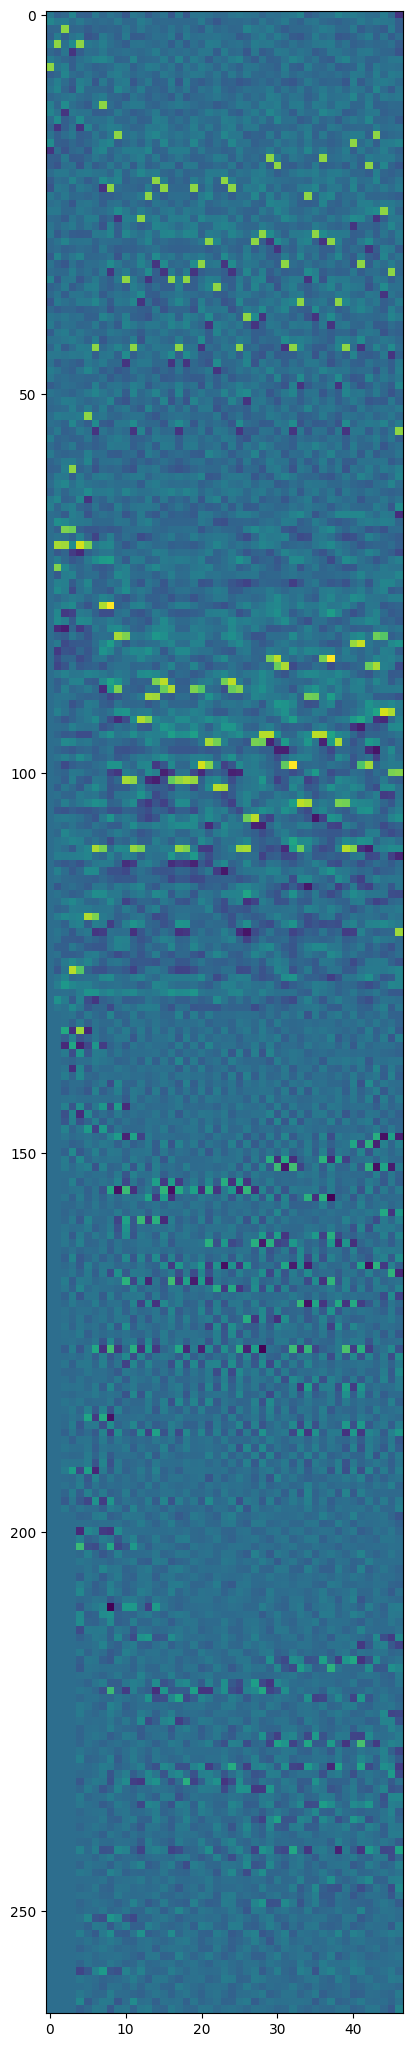

ROMEO: What light through yonder window breaks?
Come, my soul of my swrying pierch;
White's nose and the loggest be looks you have
Carrain'd; a jealouragemen: I humble. But vassal purpose, for thee;
When, good my lord; he sits the execution and will'd may life as mech must be fury drops of niname receive our tramends
Of the unto their cidence and,
The little;
And hath hit. First ABRATUS:
Like state,
We weep in him.

BENVOLIO:
Unheld! mean myself,
Mean my sir, but hide as you seem's the hold,
Lest I leave you fire.

KING EDWARD IV:
Now, for a pluck and tree bad spirated with suddenly sovereign's in this, enough?

PETRUCHIO:
No, ho! I means my come is stricture: amischance, our state in that body, and vipens are you:
O, mightst you knows to your most honour fled!

MENENIUS:
She lamentable guilty mine own insire new-rush, and pleasure, I say.

Sweeting
speak no it. Destroy one thyself this pride,
That Ane fierced take home; and my thee 


In [101]:
import pickle

with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: What light through yonder window breaks?"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=900,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=1.0
)

print(generated)
